In [ ]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS230/Project/git/cs230_project/supervised

Mounted at /content/drive
/content/drive/MyDrive/CS230/Project/git/cs230_project/supervised


In [ ]:
#@title Imports
import numpy as np
np.random.seed(0)

from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Activation, Embedding
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
import tensorflow as tf
# Configure keras backend to run on CPU
# tf.config.set_visible_devices([], 'GPU')

import matplotlib.pyplot as plt

import argparse
from datetime import datetime

from utils import *
from parameters import FLAGS
from preprocessing import review_to_indices, embedding_layer_glove

from models.biLSTM import BiLSTM
from models.cnn import CNN
from models.transformer import Transformer


Parameters:
	dev_sample_percentage: 0.05
	data_file: /content/drive/MyDrive/CS230/Project/git/cs230_project/data/amazon_reviews_us_Electronics_v1_00.tsv
	data_file2: /content/drive/MyDrive/CS230/Project/git/cs230_project/data/amazon_reviews_us_Kitchen_v1_00.tsv
	word2vec_file: /content/drive/MyDrive/CS230/Project/git/cs230_project/data/glove.6B.100d.txt
	min_total_votes: 5
	max_review_word_count: 200
	keep_start_of_longer_reviews: True
	batch_size: 32
	num_epochs: 50
	debug_mode: False


In [ ]:
#@title Load and split data sets and labels

X, Y = load_data(FLAGS.data_file,
                 FLAGS.min_total_votes,
                 FLAGS.max_review_word_count,
                 FLAGS.keep_start_of_longer_reviews)

# First split into train and (dev+test)
X_train, X_dev_test, Y_train, Y_dev_test = \
    train_test_split(X, Y, test_size=FLAGS.dev_sample_percentage*2,
                     random_state=42)
# Then split (dev+test) into dev and test
X_dev, X_test, Y_dev, Y_test = \
    train_test_split(X_dev_test, Y_dev_test, test_size=0.5, random_state=42)

Loading data ...
Data loaded. Found 291203 data points with >= 5 total votes.


In [ ]:
#@title Print dataset sizes

print(f'Examples in X_train: {X_train.shape[0]}')
print(f'Examples in X_dev:    {X_dev.shape[0]}')
print(f'Examples in X_test:   {X_test.shape[0]}')

Examples in X_train: 262082
Examples in X_dev:    14560
Examples in X_test:   14561


In [ ]:
#@title Print some examples from the dataset
for idx in range(3):
    print(X_train[idx], '\n', Y_train[idx])
    print('\n')

In [ ]:
#@title Create inputs for Embedding layer
word_to_index, index_to_word, word_to_vec_map = \
    read_glove_vecs(FLAGS.word2vec_file)

Creating word embeddings matrix ...
Done


In [ ]:
#@title Create instance of CNN

model_cnn = CNN((FLAGS.max_review_word_count, ),
                word_to_vec_map,
                word_to_index,
                FLAGS)
model_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          40000100  
                                                                 
 reshape_1 (Reshape)         (None, 200, 100, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 198, 98, 8)        80        
                                                                 
 re_lu_3 (ReLU)              (None, 198, 98, 8)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 33, 8)        0         
 2D)                                                             
                                                               

In [ ]:
#@title Create instance of BiLSTM

model_biLSTM = BiLSTM((FLAGS.max_review_word_count, ),
                      word_to_vec_map,
                      word_to_index,
                      lstm_units=[32, 64])
model_biLSTM.summary()

Model: "biLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          40000100  
                                                                 
 bidirectional (Bidirectiona  (None, 200, 64)          34048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0    

In [ ]:
#@title Create instance of Transformer
model_transformer = Transformer((FLAGS.max_review_word_count, ),
                                word_to_vec_map,
                                word_to_index,)
model_transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 100)         40020100  
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 200, 100)         127932    
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 100)               

In [ ]:
#@title Compile models

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-2),
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=['mse', 'mean_absolute_error'])

model_biLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                     loss=tf.keras.losses.MeanAbsoluteError(),
                     metrics=['mse', 'mean_absolute_error'])

model_transformer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                          loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=['mse', 'mean_absolute_error'])

In [ ]:
#@title Get indices for all words. Use these as inputs!

X_train_indices = review_to_indices(X_train,
                                    word_to_index,
                                    FLAGS.max_review_word_count)
X_dev_indices   = review_to_indices(X_dev,
                                    word_to_index,
                                    FLAGS.max_review_word_count)
X_test_indices   = review_to_indices(X_test,
                                     word_to_index,
                                     FLAGS.max_review_word_count)

In [ ]:
#@title Set up checkpoints

checkpoint_filepath = ...
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

In [ ]:
#@title Train CNN

cnn_history = model_cnn.fit(X_train_indices, Y_train,
                            epochs=FLAGS.num_epochs,
                            batch_size=FLAGS.batch_size,
                            shuffle=True,
                            validation_data=(X_dev_indices, Y_dev),
                            callbacks=[model_checkpoint_callback])

In [ ]:
#@title Train LSTM

biLSTM_history = model_biLSTM.fit(X_train_indices, Y_train,
                                  epochs=FLAGS.num_epochs,
                                  batch_size=FLAGS.batch_size,
                                  shuffle=True,
                                  validation_data=(X_dev_indices, Y_dev),
                                  callbacks=[model_checkpoint_callback])

In [ ]:
#@title Train Transformer

transformer_histroy = model_transformer.fit(
                                     X_train_indices, Y_train,
                                     epochs=FLAGS.num_epochs,
                                     batch_size=FLAGS.batch_size,
                                     shuffle=True,
                                     validation_data=(X_dev_indices, Y_dev),
                                     callbacks=[model_checkpoint_callback])

In [ ]:
#@title Load trained models and evaluate

checkpoint_filepath_CNN_best = '/content/drive/MyDrive/CS230/Project/git/cs230_project/supervised/trained_models/cnn_60epochs.ckpt'
model_CNN_loaded = tf.keras.models.load_model(checkpoint_filepath_CNN_best)
model_CNN_loaded.evaluate(X_test_indices, Y_test, verbose=2)

checkpoint_filepath_LSTM_best = '/content/drive/MyDrive/CS230/Project/git/cs230_project/supervised/trained_models/bi_60epochs.ckpt'
model_biLSTM_loaded = tf.keras.models.load_model(checkpoint_filepath_LSTM_best)
model_biLSTM_loaded.evaluate(X_test_indices, Y_test, verbose=2)

checkpoint_filepath_transformer_best = '/content/drive/MyDrive/CS230/Project/git/cs230_project/supervised/trained_models/transformer_50epochs.ckpt'
model_transformer_loaded = tf.keras.models.load_model(
                               checkpoint_filepath_transformer_best)
model_transformer_loaded.evaluate(X_test_indices, Y_test, verbose=2)

456/456 - 3s - loss: 0.1864 - mse: 0.0679 - mean_absolute_error: 0.1864 - 3s/epoch - 7ms/step
456/456 - 8s - loss: 0.1707 - mse: 0.0564 - mean_absolute_error: 0.1689 - 8s/epoch - 17ms/step
456/456 - 3s - loss: 0.1745 - mse: 0.0609 - mean_absolute_error: 0.1733 - 3s/epoch - 6ms/step


[0.17454980313777924, 0.06091686338186264, 0.173341304063797]

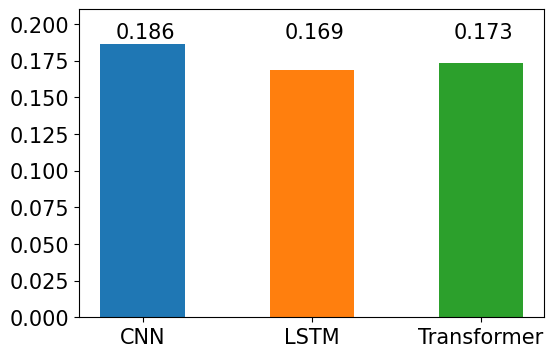

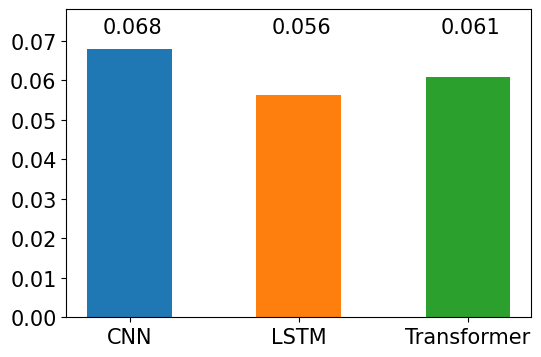

In [ ]:
#@title Plot results on test set

mean_absolute_errors_test = {'CNN': 0.1864,
                             'LSTM': 0.1689,
                             'Transformer': 0.1733}
mean_squared_errors_test = {'CNN': 0.0679,
                            'LSTM': 0.0564,
                            'Transformer': 0.0609}

# Plot mean absolute errors
plt.figure(figsize=(6, 4))
for i, value in enumerate(mean_absolute_errors_test.values()):
    plt.bar(i, value, width=0.5)
    plt.text(i-0.16, 0.19, str(np.round(value, 3)), fontsize=15)
plt.xticks(list(range(len(mean_absolute_errors_test))),
           list(mean_absolute_errors_test.keys()),
           fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0, 0.21])
plt.show()

# Plot mean squared errors
plt.figure(figsize=(6, 4))
for i, value in enumerate(mean_squared_errors_test.values()):
    plt.bar(i, value, width=0.5)
    plt.text(i-0.16, 0.072, str(np.round(value, 3)), fontsize=15)
plt.xticks(list(range(len(mean_squared_errors_test))),
           list(mean_squared_errors_test.keys()),
           fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0, 0.078])
plt.show()

In [ ]:
#@title Predict on single examples

ex_nums = [517, 44, 8]
cnn_pred_exs         = []
lstm_pred_exs        = []
transformer_pred_exs = []
for ex_num in ex_nums:
    assert ex_num >= 0 and ex_num < X_test_indices.shape[0]
    print(len(X_test[ex_num].split(' ')))
    print(X_test[ex_num])
    ex = np.array(X_test_indices[ex_num]).reshape(1, -1)

    cnn_pred_ex         = model_CNN_loaded.predict(ex, verbose=0)[0][0]
    lstm_pred_ex        = model_biLSTM_loaded.predict(ex, verbose=0)[0][0]
    transformer_pred_ex = model_transformer_loaded.predict(ex, verbose=0)[0][0]

    cnn_pred_exs.append(cnn_pred_ex)
    lstm_pred_exs.append(lstm_pred_ex)
    transformer_pred_exs.append(transformer_pred_ex)

    print(f'Label:       {Y_test[ex_num]:.2f}')
    print(f'CNN:         {cnn_pred_ex:.2f}')
    print(f'LSTM:        {lstm_pred_ex:.2f}')
    print(f'Transformer: {transformer_pred_ex:.2f}')
    print('')

86
pros its small , does n't need batteries , holds lots of songs , sound is great , can make folders to organize player long battery life cons manual not to detail , had to call tech support to help get music on player because the manual does not tell u once that was done it was very easy to get music on my player , u may want better head phones so far am loving my new product very pleased and the price was great
Label:       0.93
CNN:         0.82
LSTM:        0.84
Transformer: 0.87

3
not enough bass
Label:       0.38
CNN:         0.25
LSTM:        0.19
Transformer: 0.18

21
this adapter does not have the proper plug to use with the acer iconia tab a100 do n't waste your money
Label:       1.00
CNN:         0.55
LSTM:        0.87
Transformer: 0.69



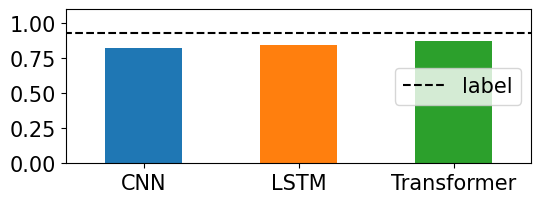

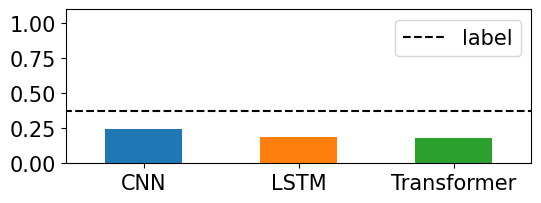

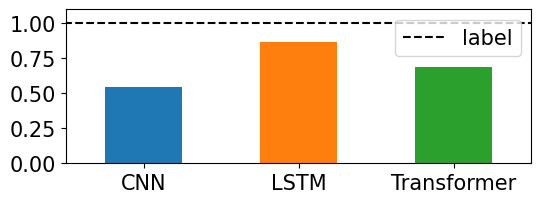

In [ ]:
#@title Plot prediction on test example

def plot_pred_on_testex(label, cnn_pred, lstm_pred,
                        transformer_pred, legend_pos):
    plt.figure(figsize=(6, 2))

    plt.plot([-0.8, 3.8], [label, label], 'k--', label='label')
    plt.legend(loc=legend_pos, fontsize=15)

    plt.bar(0, cnn_pred, width=0.5)
    plt.bar(1, lstm_pred, width=0.5)
    plt.bar(2, transformer_pred, width=0.5)

    plt.xticks(list(range(3)),
               ['CNN', 'LSTM', 'Transformer'],
               fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim([-0.5, 2.5])
    plt.ylim([0, 1.1])
    plt.show()


for i, legend_pos in enumerate(['center right', 'upper right', 'upper right']):
    plot_pred_on_testex(Y_test[ex_nums[i]], cnn_pred_exs[i], lstm_pred_exs[i],
                        transformer_pred_exs[i], legend_pos)